In [1]:
from simplex import simplex
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import numpy as np

Let us consider a simplex example of a farmer that has some land to allocate between two different crops. The farmer has to allocate:
* $x_1$ acres for corn 
* $x_2$ acres for oats

The profit/per acre for each crop is:
* $40/acre for corn
* $30/acre for oats

The farmer has:
* 240 acres of land
* 320 labour hours
* corn takes 2hr/acre to plant
* oats take 1hr/acre to plant

We can formulate the previous problem statement as an optimization problem, where the objective is the profits, and the constraints are the amount of land and labour hours available.

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{max}}
		& f(x_1,x_2) & = 40x_1 + 30x_2 \\
		& \text{subject to}
		& 2x_1+x_2 & \leq320~~(\textrm{labour~constraint})\\
        & & x_1+x_2 & \leq240~~(\textrm{land~constraint})\\
		& & x_1 & \geq0\\
		& & x_2 & \geq0\\
	\end{aligned}
\end{equation*}

We turn it into a minimization problem:

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{min}}
		& f(x_1,x_2) & = -40x_1 - 30x_2 \\
		& \text{subject to}
		& 2x_1+x_2 & \leq320~~(\textrm{labour~constraint})\\
        & & x_1+x_2 & \leq240~~(\textrm{land~constraint})\\
		& & x_1 & \geq0\\
		& & x_2 & \geq0\\
	\end{aligned}
\end{equation*}

# Solving the problem by graphing and inspection

We can solve this linear programming problem by looking at the feasible region since its just a 2D problem. We know that the optimal solution will be one of the vertices of the polygon formed by the feasible region.

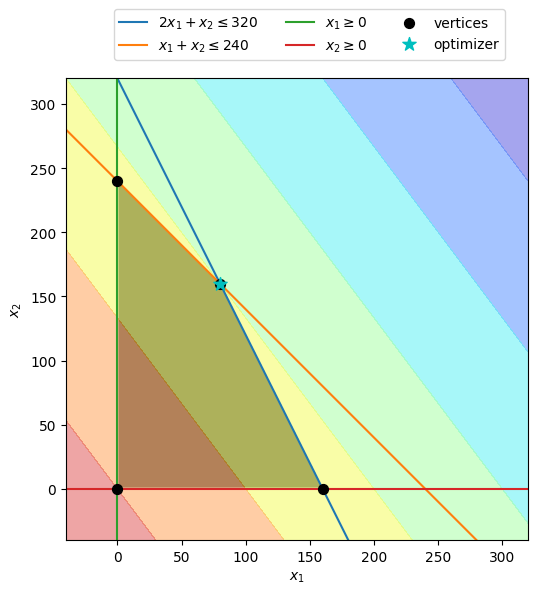

In [2]:
# plot the feasible region
d = np.linspace(-40,320,300)
X1,X2 = np.meshgrid(d,d)
F = -40*X1-30*X2
G1=2*X1+X2<=320
G2=X1+X2<=240
G3=X1>=0
G4=X2>=0

# plot the lines defining the constraints
x = d
# 2*x1+x2<=320
g1=(320-2*x)/1
# x1+x2<=240
g2=(240-x)/1
# x1<=5
g3=x # vertical line
# x2>=-5
g4=0*np.ones_like((x)) # horizontal line

x_opts = np.array([[0.,0.],
                [0.,240.],
                [160.,0.],
                [80.,160.],
                ])

# Make plot
fig, ax = plt.subplots(figsize=(7,6))
ax.imshow( (G1 & G2 & G3 & G4).astype(int) , 
                extent=(X1.min(),X1.max(),X2.min(),X2.max()),origin="lower", cmap="Greys", alpha = 0.3)
ax.contourf(X1,X2,F,cmap="jet",alpha=0.5,zorder=-1)
ax.plot(x, g1, label=r"$2x_1+x_2\leq320$")
ax.plot(x, g2, label=r"$x_1+x_2\leq240$")
ax.plot(0*np.ones_like(g3), g3, label=r"$x_1\geq0$")
ax.plot(x, g4, label=r"$x_2\geq0$")
ax.scatter(x_opts[:,0],x_opts[:,1],color="k",s=50,zorder=2,label="vertices")
ax.scatter(x_opts[-1,0],x_opts[-1,1],color="c",s=100,marker="*",zorder=3,label="optimizer")
ax.set_xlim(-40,320)
ax.set_ylim(-40,320)
ax.legend(bbox_to_anchor=(0.95, 1.15), loc=1, borderaxespad=0., ncol=3)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$");
# fig.savefig("simplex_vertices.pdf",bbox_inches="tight")
# fig.savefig("simplex_novertices.pdf",bbox_inches="tight")
# fig.savefig("simplex_nofeasible.pdf",bbox_inches="tight")
# fig.savefig("simplex_optimal.pdf",bbox_inches="tight")

We can see that the above polygon has four vertices. We substitute their values into the objective function to find out which is the optimal solution

\begin{align*}
(0,0)       & \rightarrow~f=0.0~(\mathrm{degenerate~solution})\\
(0,240)     & \rightarrow~f=-7200\\
(160,0)     & \rightarrow~f=-6400\\
(80,160)    & \rightarrow~f=-8000~(\mathrm{optimal~solution})\\
\end{align*}

We can see that $(80~\mathrm{acres~corn},160~\mathrm{acres~oats})$ is the optimizer.

This approach is doable for simple problems that have small $m$ (number of constraints) and small $n$ (number of variables).

We use a more systematic approach in the next section to solve the same problem.

# Solving the problem by finding the basic solutions

We can solve the previous problem by stating it in standard form and finding the basic solutions of the system of equations $\mathbf{A}\mathbf{x}=\mathbf{b}$

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{min}}
		& f(x_1,x_2) & = -40x_1 - 30x_2 \\
		& \text{subject to}
		& 2x_1+x_2+s_1& = 320~~(\textrm{labour~constraint})\\
        & & x_1+x_2+s_2& = 240~~(\textrm{land~constraint})\\
		& & x_1 & \geq0\\
		& & x_2 & \geq0\\
		& & s_1 & \geq0\\
		& & s_2 & \geq0\\
	\end{aligned}
\end{equation*}

giving us

$$
\mathbf{A} = \begin{bmatrix} 
    2 & 1 & 1 & 0\\
	1 & 1 & 0 & 1\\
	\end{bmatrix}
\mathbf{b} = \begin{bmatrix} 320 \\ 240 \end{bmatrix}\\
~\\
\mathbf{c} = \begin{bmatrix} -40 & -30 & 0 & 0\end{bmatrix}^\mathrm{T}
$$

$\mathbf{A}$ is a $2\times4$ matrix giving us $n=4$ and $m=2$. Therefore, we have $M = \begin{pmatrix} n \\ m \end{pmatrix} = \dfrac{n!}{m!(n-m)!} = 6$ basic solutions

In [3]:
from itertools import combinations

A = np.array([[2,1,1,0],
              [1,1,0,1]], dtype="float64")
b = np.array([320,240], dtype="float64")
c = np.array([-40,-30,0,0], dtype="float64")

m = A.shape[1]
n = A.shape[0]

combs = combinations(range(m), n) # possible combinations of m with n selections

for i,comb in enumerate(combs):
    # initialize solution vector
    print("basic solution %i" %(i+1))
    print("sub matrix for basic variables : [%s]" %(', '.join(['x%i']*len(comb)) % tuple([i+1 for i in comb])))
    x = np.zeros((m,1))
    Ab = A[:,comb]
    print("Ab =\n",Ab)
    xb = np.linalg.inv(Ab) @ b # basic solution
    if any(xb<0):
        print("INFEASIBLE!")
    print("x basic =",xb)
    x[comb,:] = xb[:,None] # substitute basic solutions (non basic solutions are zero by default)
    print("x =",x.squeeze())
    print("f basic =",(c.T @ x).squeeze())
    print("===============")

basic solution 1
sub matrix for basic variables : [x1, x2]
Ab =
 [[2. 1.]
 [1. 1.]]
x basic = [ 80. 160.]
x = [ 80. 160.   0.   0.]
f basic = -8000.0
basic solution 2
sub matrix for basic variables : [x1, x3]
Ab =
 [[2. 1.]
 [1. 0.]]
INFEASIBLE!
x basic = [ 240. -160.]
x = [ 240.    0. -160.    0.]
f basic = -9600.0
basic solution 3
sub matrix for basic variables : [x1, x4]
Ab =
 [[2. 0.]
 [1. 1.]]
x basic = [160.  80.]
x = [160.   0.   0.  80.]
f basic = -6400.0
basic solution 4
sub matrix for basic variables : [x2, x3]
Ab =
 [[1. 1.]
 [1. 0.]]
x basic = [240.  80.]
x = [  0. 240.  80.   0.]
f basic = -7200.0
basic solution 5
sub matrix for basic variables : [x2, x4]
Ab =
 [[1. 0.]
 [1. 1.]]
INFEASIBLE!
x basic = [320. -80.]
x = [  0. 320.   0. -80.]
f basic = -9600.0
basic solution 6
sub matrix for basic variables : [x3, x4]
Ab =
 [[1. 0.]
 [0. 1.]]
x basic = [320. 240.]
x = [  0.   0. 320. 240.]
f basic = 0.0


We can see that we have 6 basic solutions, 2 of which are infeasible. The 4 feasible solutions correspond to the vertices of the feasible region with $(80,160)$ being the optimal basic solution.

# Solving the problem using the simplex algorithm

The previous method works well when $M = \begin{pmatrix} n \\ m \end{pmatrix} = \dfrac{n!}{m!(n-m)!}$ is reasonable. If we have $n = 100$ and $m = 50$, we have $M = 1.0089\times10^{29}$ basic solutions. We cannot check all of them. The simplex algorithm jumps from one vertex to the other intelligently such that it arrives at the optimal solution with out having to check each and every vertex.

We show the simplex iterations below and print the value of the tableau $\mathbf{A}_k$, $\mathbf{b}_k$, and $\mathbf{c}_k$ at each iteration $k$ with $\mathbf{A}_0$, $\mathbf{b}_0$, and $\mathbf{c}_0$ taken from the the previous section

In [4]:
A = np.array([[2,1,1,0],
              [1,1,0,1]], dtype="float64")
b = np.array([320,240], dtype="float64")
c = np.array([-40,-30,0,0], dtype="float64")

c0 = c.copy()
k = 0
stop = False

k = 0
print("==================")
print("Simplex iterations")
z_opts = np.array([[0.0,0.0]])
while not stop:
    x_opt,stop = simplex(A,b,c)

    if not stop:
        k+=1
        print("iteration = %i" %k)
        print("A =", A)
        print("c =",c)
        print("b =",b)

    f_opt = c0[None,:] @ x_opt[:,None]
    z_opt = x_opt[0:2]
    z_opts = np.vstack((z_opts,z_opt))
    print("f_opt =",f_opt)
    print("x_opt =",x_opt)
    print("z_opt =",z_opt)

    print("==================")
    # input("hit ENTER to continue")

Simplex iterations
iteration = 1
A = [[ 1.   0.5  0.5  0. ]
 [ 0.   0.5 -0.5  1. ]]
c = [  0. -10.  20.   0.]
b = [160.  80.]
f_opt = [[0.]]
x_opt = [  0.   0. 320. 240.]
z_opt = [0. 0.]
iteration = 2
A = [[ 1.  0.  1. -1.]
 [ 0.  1. -1.  2.]]
c = [ 0.  0. 10. 20.]
b = [ 80. 160.]
f_opt = [[-6400.]]
x_opt = [160.   0.   0.  80.]
z_opt = [160.   0.]
solution terminated
f_opt = [[-8000.]]
x_opt = [ 80. 160.   0.   0.]
z_opt = [ 80. 160.]


We can see that the algorithm terminated in exactly two iterations. We plot the progress of the algorithm on the previous plot of the feasible region.

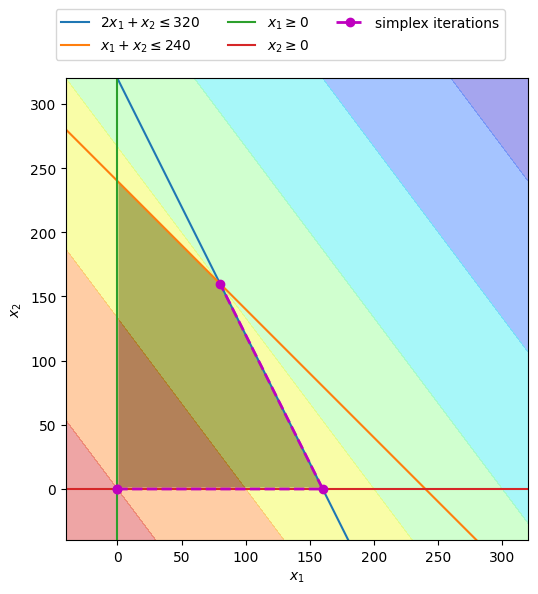

In [5]:
# plot the feasible region
d = np.linspace(-40,320,300)
X1,X2 = np.meshgrid(d,d)
F = -40*X1-30*X2
G1=2*X1+X2<=320
G2=X1+X2<=240
G3=X1>=0
G4=X2>=0

# plot the lines defining the constraints
x = d
# 2*x1+x2<=320
g1=(320-2*x)/1
# x1+x2<=240
g2=(240-x)/1
# x1<=5
g3=x # vertical line
# x2>=-5
g4=0*np.ones_like((x)) # horizontal line

# Make plot
fig, ax = plt.subplots(figsize=(7,6))
ax.imshow( (G1 & G2 & G3 & G4).astype(int) , 
                extent=(X1.min(),X1.max(),X2.min(),X2.max()),origin="lower", cmap="Greys", alpha = 0.3)
ax.contourf(X1,X2,F,cmap="jet",alpha=0.5,zorder=-1)
ax.plot(x, g1, label=r"$2x_1+x_2\leq320$")
ax.plot(x, g2, label=r"$x_1+x_2\leq240$")
ax.plot(0*np.ones_like(g3), g3, label=r"$x_1\geq0$")
ax.plot(x, g4, label=r"$x_2\geq0$")
ax.plot(z_opts[:,0], z_opts[:,1],marker="o",linestyle="--",color="m",linewidth=2.0,label=r"simplex iterations")
ax.set_xlim(-40,320)
ax.set_ylim(-40,320)
ax.legend(bbox_to_anchor=(0.95, 1.15), loc=1, borderaxespad=0., ncol=3)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$");
# fig.savefig("simplex_iterations_3.pdf",bbox_inches="tight")